In [ ]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
import sklearn
from tqdm import tqdm
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
%matplotlib inline
import datetime

Загрузим таблицы



In [ ]:
action_train = pd.read_csv('action_train.csv')
action_test = pd.read_csv('action_test.csv')
person = pd.read_csv('person.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Предобработаем данные:**

1.   Уберем ненужный первый столбец, обозначующий номер строки
2. Преобразуем столбец с датами в datetime формат
3. Заменим логические значения признаков на 1 и -1
4. Избавимся от 'ppl' в столбце  person_id
5. Заполним пропуски нулями



In [ ]:
def prepocessing (df):
  df = df.drop(['N'], axis=1)
  df['date'] = pd.to_datetime(df['date'])
  df = df.fillna(0).astype('str')
  df[df == 'True'] = 1.
  df[df == 'False'] = -1.
  df['person_id'] = df['person_id'].str.replace('ppl_', '').astype('float')
  return df

In [ ]:
action_train = prepocessing(action_train)
action_test = prepocessing(action_test)
person = prepocessing(person)

Отдельно для action_train и action_test заменим признак типа 'type_i' на i:

In [ ]:
def F(df):
    for i in np.arange(1, 11, 1):
        s = 'char_' + str(i)
        (i)
        df[s] = df[s].str.replace('type ', '').astype('int')
    s = 'action_type'
    df[s] = df[s].str.replace('type ', '').astype('int')
    return df

In [ ]:
action_test = F(action_test)
action_train = F(action_train)
action_train['result'] = action_train['result'].astype('float')

In [ ]:
action_train.head()

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result
0,100.0,act2_1734928,2023-08-26,4,0,0,0,0,0,0,0,0,0,76,0.0
1,100.0,act2_2434093,2022-09-27,2,0,0,0,0,0,0,0,0,0,1,0.0
2,100.0,act2_3404049,2022-09-27,2,0,0,0,0,0,0,0,0,0,1,0.0
3,100.0,act2_3651215,2023-08-04,2,0,0,0,0,0,0,0,0,0,1,0.0
4,100.0,act2_4109017,2023-08-26,2,0,0,0,0,0,0,0,0,0,1,0.0


В таблице person сделаем то же самое( к 'char_i' и 'group_1')

In [ ]:
def f(df):
    for i in np.arange(1, 39, 1):
        s = 'char_' + str(i)
        df[s] = df[s].astype('str')
        df[s] = df[s].str.replace('type ', '').astype('float')
    s = 'group_1'
    df[s] = df[s].str.replace('group ', '').astype('float')
    return df

In [ ]:
person = f(person)

Заметим, что в action_id есть параметр и номер. Выделим параметр в отдельный столбец:

In [ ]:
action_train['group_of_action_id'] = action_train['action_id'].str[3].astype('float')
action_test['group_of_action_id'] = action_test['action_id'].str[3].astype('float')

In [ ]:
 action_train['group_of_action_id'].unique()

array([2., 1.])

In [ ]:
def X(df):
    for i in (1, 2):
      df['action_id'] = df['action_id'].str.replace('act' + str(i) +'_', '')
    return df


In [ ]:
action_train = X(action_train)
action_train['action_id'] = action_train['action_id'].astype('float')

Для того, чтобы понять есть ли взаимосвязь между отдельными признаками и 'result', построим гистограммы распределения значений признаков для двух классов: result = 1 или result = 0. Каждый график содержит две наложенные друг на друга гистограммы, первая – для всех точек, относящихся к классу «result = 1», а вторая – для всех точек, относящихся к классу «result = 0» (зеленый цвет). Это дает нам некоторое представление о распределении каждого признака по двум классам и позволяет нам строить предположения о том, какие признаки лучше всего дискриминируют result = 0 и result = 1.

**Строим для action_train**

Для удобства в начале отдеьлно построим гистограммы для времени. Видно, что они друг друга накрывают, поэтому использовать время как признак в модели мы в будущем не будем. 

(array([176815., 129051., 100005., 157502., 112695., 102339.,  75608.,
         61855.,  48450.,  11177.]),
 array([  0.,  41.,  82., 123., 164., 205., 246., 287., 328., 369., 410.]),
 <a list of 10 Patch objects>)

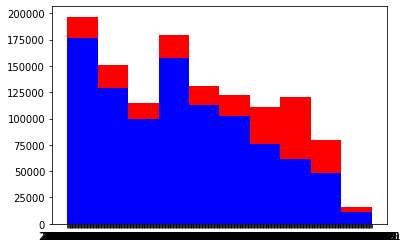

In [ ]:
non = action_train[action_train.result == 0] 
yes = action_train[action_train.result == 1]
plt.hist(non[non['date'] != 0]['date'], color='red')
plt.hist(yes[yes['date'] != 0]['date'], color = 'blue')

In [ ]:
action_train = action_train.drop('date', axis=1)

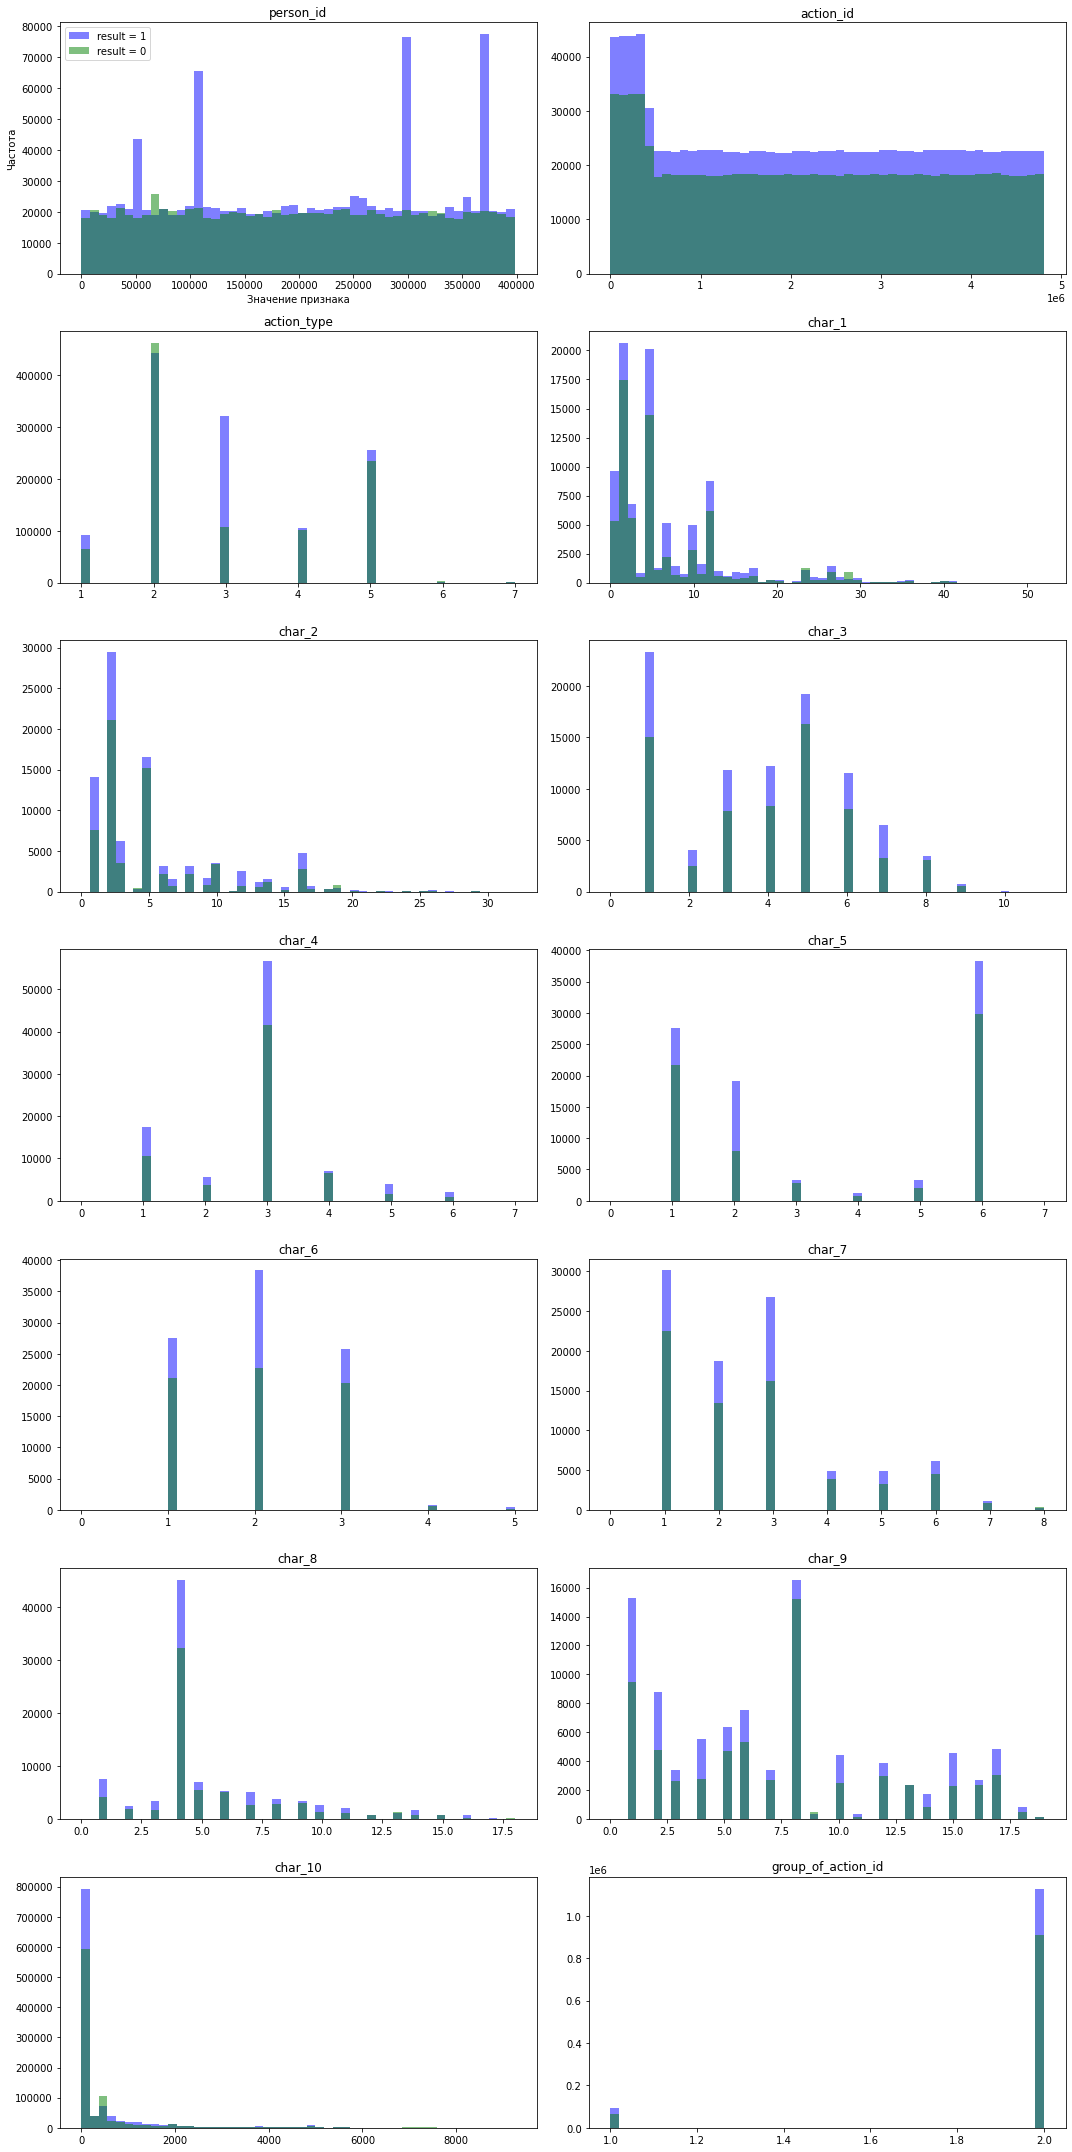

In [ ]:
fig, axes = plt.subplots(7, 2, figsize=(15, 30)) 
non = action_train[action_train.result == 0] 
yes = action_train[action_train.result == 1]
ax = axes.ravel()

for i in range(0, 13):
    _, bins = np.histogram(action_train.iloc[:, i], bins=50) 
    ax[i].hist(non[non.iloc[:, i] != 0].iloc[:, i], color = 'blue', bins=bins, alpha=.5) 
    ax[i].hist(yes[yes.iloc[:, i] != 0].iloc[:, i], bins=bins,color='green',  alpha=.5)
    if i ==0:
        ax[i].set_title('person_id')
    elif i==1:
      ax[i].set_title('action_id')
    elif i==2:
      ax[i].set_title('action_type')  

    else:
      ax[i].set_title('char_' + str(i-2))
_, bins = np.histogram(action_train.iloc[:, 14], bins=50) 
ax[13].hist(non[non.iloc[:, 14] != 0].iloc[:, 14], color = 'blue', bins=bins, alpha=.5) 
ax[13].hist(yes[yes.iloc[:, 14] != 0].iloc[:, 14], bins=bins,color='green',  alpha=.5)  
ax[13].set_title('group_of_action_id')

  
ax[0].set_xlabel("Значение признака") 
ax[0].set_ylabel("Частота")
ax[0].legend(["result = 1", 'result = 0'], loc="best") 

fig.tight_layout()

**Строим для person, объединив с action_train по 'person_id'**

In [ ]:
Person = pd.merge(person, action_train[['person_id', 'result', 'action_id', 'group_of_action_id']], on='person_id').drop('date', axis=1)

In [ ]:
Person.head()

,person_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,...,char_32,char_33,char_34,char_35,char_36,char_37,char_38,result,action_id,group_of_action_id
0,100.0,2.0,17304.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,...,-1.0,-1.0,1.0,1.0,1.0,-1.0,36.0,0.0,1734928.0,2.0
1,100.0,2.0,17304.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,...,-1.0,-1.0,1.0,1.0,1.0,-1.0,36.0,0.0,2434093.0,2.0
2,100.0,2.0,17304.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,...,-1.0,-1.0,1.0,1.0,1.0,-1.0,36.0,0.0,3404049.0,2.0
3,100.0,2.0,17304.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,...,-1.0,-1.0,1.0,1.0,1.0,-1.0,36.0,0.0,3651215.0,2.0
4,100.0,2.0,17304.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,...,-1.0,-1.0,1.0,1.0,1.0,-1.0,36.0,0.0,4109017.0,2.0


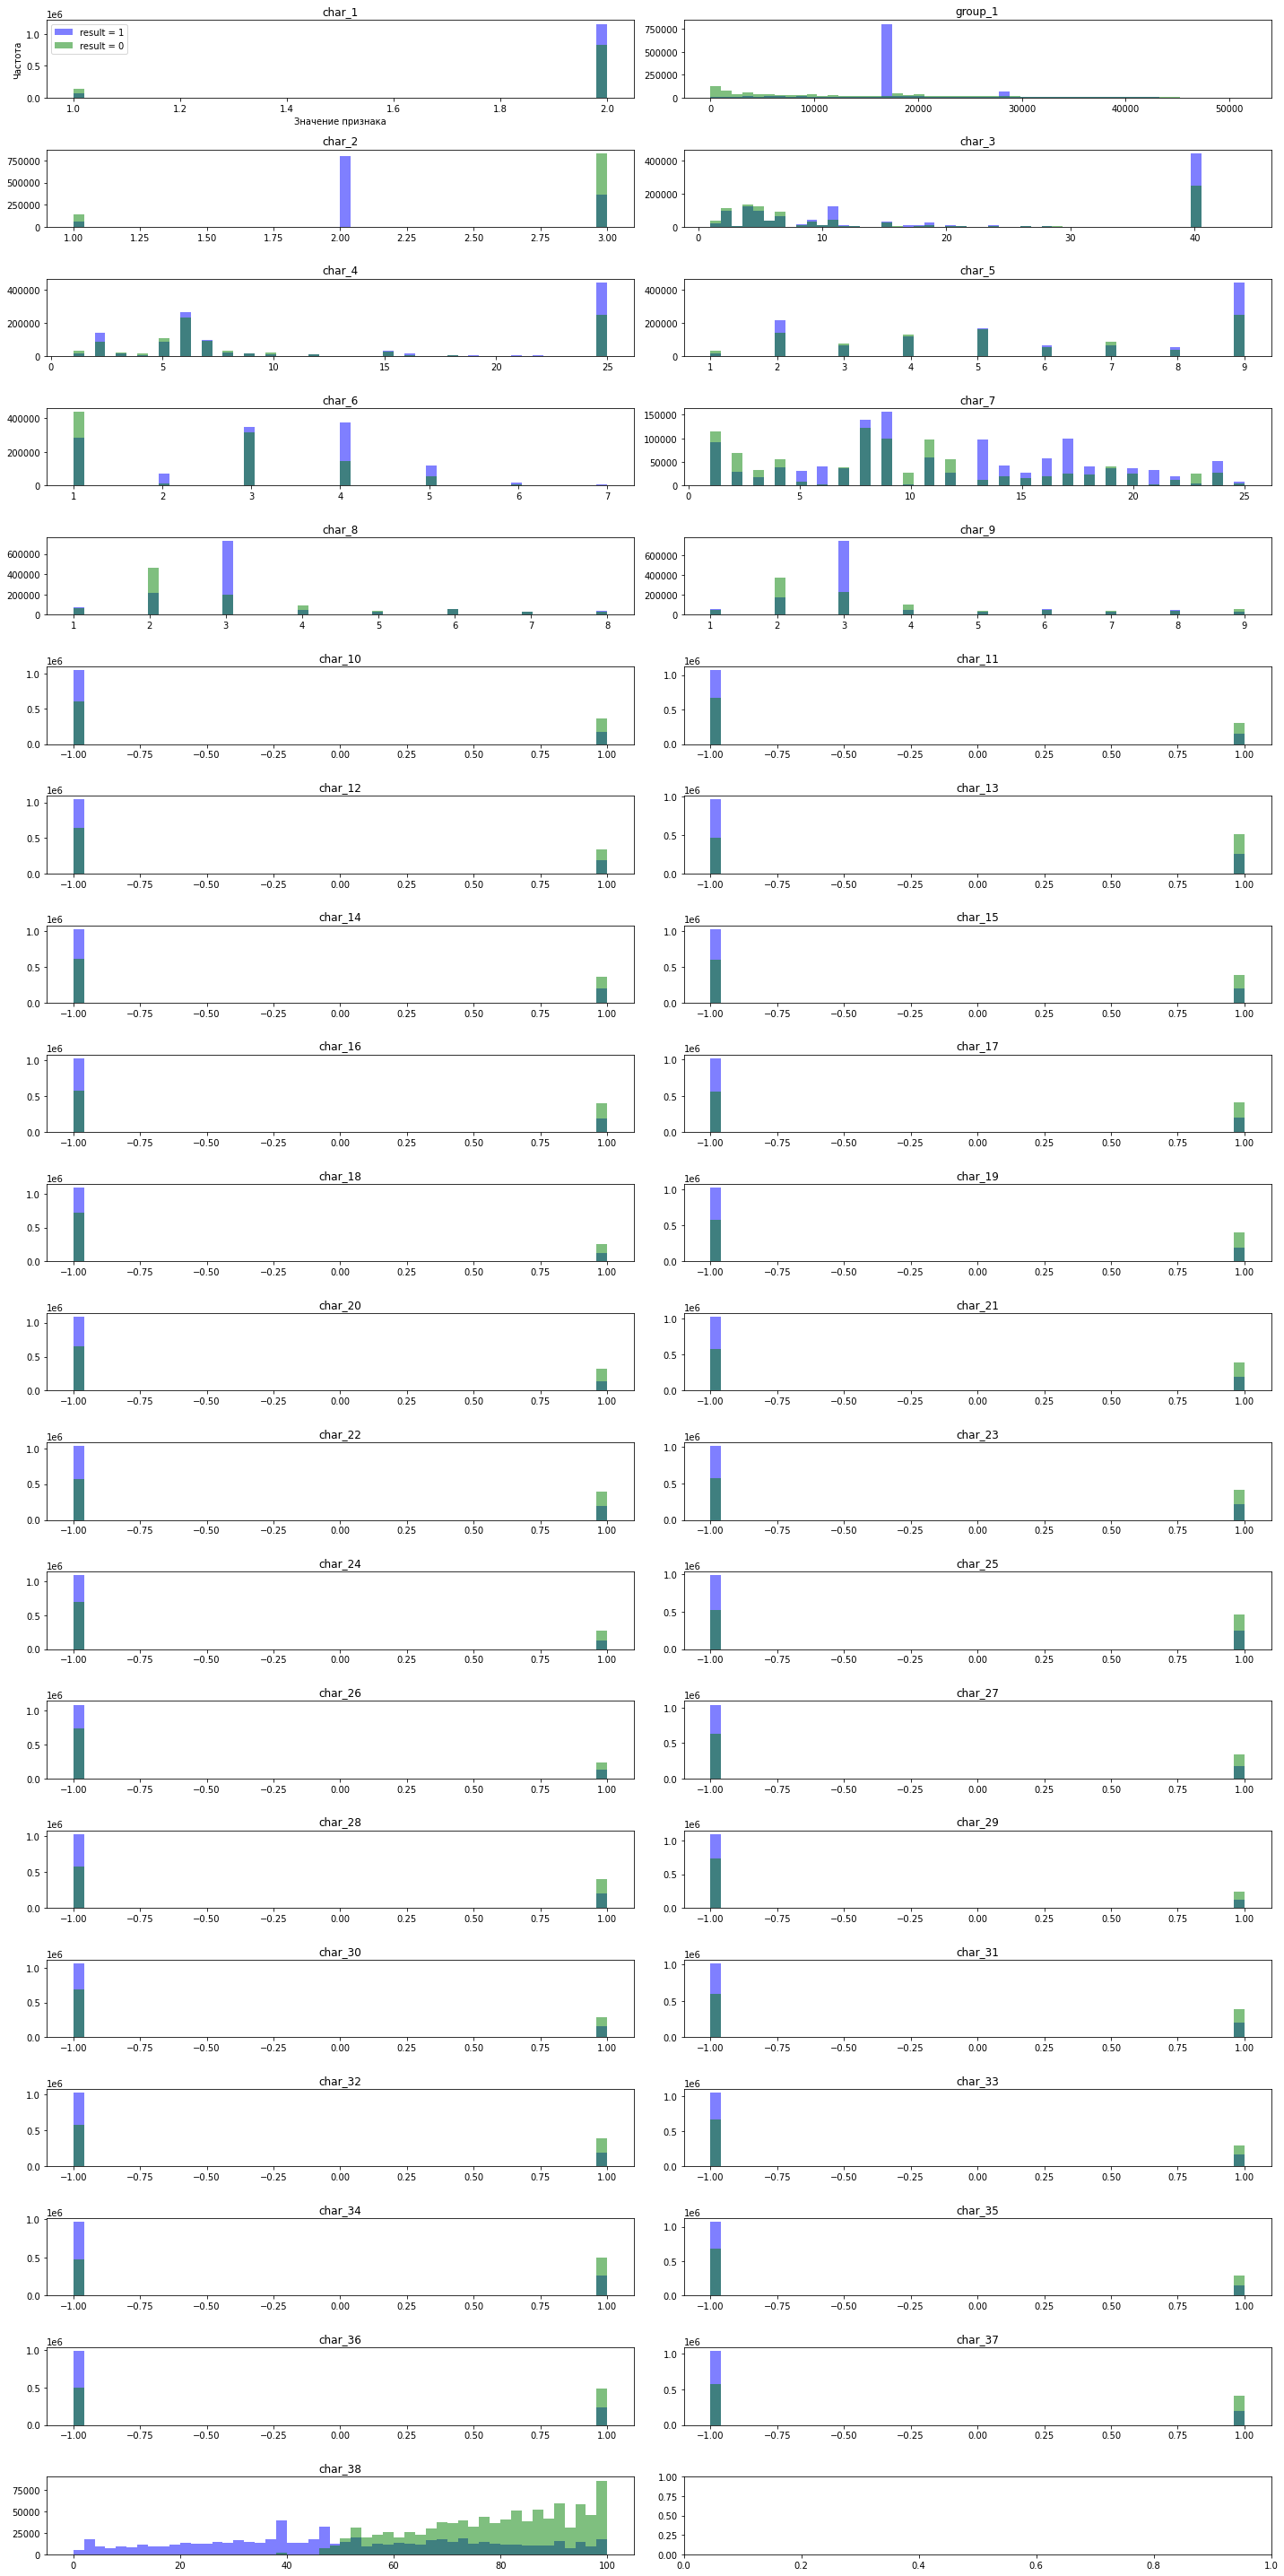

In [ ]:
fig, axes = plt.subplots(20, 2, figsize=(20, 40)) 
non = Person[Person.result == 0] 
yes = Person[Person.result == 1]
ax = axes.ravel()

_, bins = np.histogram(person.iloc[:, 1], bins=50) 
ax[0].hist(non[non.iloc[:, 1] != 0].iloc[:, 1], color = 'blue', bins=bins, alpha=.5) 
ax[0].hist(yes[yes.iloc[:, 1] != 0].iloc[:, 1], bins=bins,color='green',  alpha=.5)
ax[0].set_title('char_1')

_, bins = np.histogram(person.iloc[:, 2], bins=50) 
ax[1].hist(non[non.iloc[:, 2] != 0].iloc[:, 2], color = 'blue', bins=bins, alpha=.5) 
ax[1].hist(yes[yes.iloc[:, 2] != 0].iloc[:, 2], bins=bins,color='green',  alpha=.5)
ax[1].set_title('group_1')
for i in range(3, 40):
    _, bins = np.histogram(Person.iloc[:, i], bins=50) 
    ax[i-1].hist(non[non.iloc[:, i] != 0].iloc[:, i], color = 'blue', bins=bins, alpha=.5) 
    ax[i-1].hist(yes[yes.iloc[:, i] != 0].iloc[:, i], bins=bins,color='green',  alpha=.5) 
    ax[i-1].set_title('char_' + str(i-1))
ax[0].set_xlabel("Значение признака") 
ax[0].set_ylabel("Частота")
ax[0].legend(["result = 1", "result = 0"], loc="best") 

fig.tight_layout()

Проведем  анализ:
Глядя на гистограммы признаков таблицы 'action train', заметно, что гистограммы на каждом признаке прекрывают друг друга. Можно лишь выделить action_type, на котором видно преобладание result = 1 на значении 3.  

На гистограммах признаков таблицы 'person' можно выдедить:

1.   group_1 (значения до 17304 дают result = 0, в 17304 количество result = 1 резко увеличивается )
2. char 2 (result = 1 при char_2 = 2)
3.   char_38 (при char_38 < 50 : result = 1, при char_38 > 50 : result = 0)

В дальнейшем построим модель с сокращенным пространством признаков


Сделаем итоговую таблицу с прзнаками 

In [ ]:
data = Person[['char_38', 'char_2', 'result']]
data['char_2_action_train'] = action_train['char_2']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data.head()

,char_38,char_2,result,char_2_action_train
0,36.0,2.0,0.0,0
1,36.0,2.0,0.0,0
2,36.0,2.0,0.0,0
3,36.0,2.0,0.0,0
4,36.0,2.0,0.0,0


In [ ]:
def split (df):
  return df.drop(['result'], axis=1), df['result']
X, y = split(data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), random_state=0, test_size=.5)

Т.к просят получить result как float от 0 до 1 и число строк очень велико, то применим алгоритм линейной регрессии.

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.46507612905746454

Рассмотрим также случайный лес

In [ ]:
rf = RandomForestRegressor().fit(X_train, y_train)
rf.score(X_test, y_test)

0.5300114843589248

Качество модели оказалось хуже. 

Для интереса применим логистическую регрессию. 

In [ ]:
clf = LogisticRegression(C=100).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8141967476329955

In [ ]:
clf = LogisticRegression(C=0.01).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8141967476329955

Результат хуже чем у алгоритма линейной регрессии, даже с учетом разных коэффициентов регуляризации. Для предсказния воспользуемся именно линейной регрессией

!!!"Метрика оценки ROC", однако алгоритм -- это регрессиия, а не классификация. Попоробуем построить ROC для регрессии, опираясь на [статью](https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb). 

На самом деле, согласно Википедии , roc_auc_score совпадает с «вероятностью того, что классификатор ранжирует случайно выбранный положительный ответ выше, чем случайно выбранный отрицательный».

Другими словами, если мы возьмем любые два наблюдения a и b , такие что a > b , тогда roc_auc_score равна вероятность того, что наша модель действительно ранжирует a выше, чем b .

Это определение гораздо полезнее для нас, потому что оно имеет смысл и для регрессии (фактически a и b не могут быть ограничены 0 или 1, они могут принимать любое непрерывное значение);

Тем более, roc_auc_scoreчто считать теперь намного проще. На самом деле все сводится к тому, чтобы рассмотреть каждую возможную пару элементов a и b , такую, что a > b , и подсчитать, во сколько раз значение, предсказанное нашей моделью для a , на самом деле выше, чем значение, предсказанное для b (возможные связи будут насчитали половину). Тогда roc_auc_score это просто количество успехов, деленное на общее количество пар.

In [ ]:
def naive_roc_auc_score(y_true, y_pred):
    
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

In [ ]:
naive_roc_auc_score(lr.predict(X_test), y_test)

Теперь сделаем предсказания

In [ ]:
def X(df):
    for i in (1, 2):
      df['action_id'] = df['action_id'].str.replace('act' + str(i) +'_', '')
    return df

In [ ]:
action_test = X(action_test)

In [ ]:
action_test['action_id'] = action_test['action_id'].astype('float')

In [ ]:
Person = pd.merge(person, action_test[['person_id',  'action_id', 'group_of_action_id']], on='person_id')

In [ ]:
data = Person[['char_38', 'char_2']]
data['char_2_action_train'] = action_test['char_2']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data.head()

,char_38,char_2,char_2_action_train
0,76.0,3.0,10
1,76.0,3.0,0
2,90.0,3.0,1
3,90.0,3.0,10
4,90.0,3.0,0


In [ ]:
X = np.array(data)

In [ ]:
lr.predict(X).shape, action_test.shape

((498687,), (498687, 15))

In [ ]:
action_test = pd.read_csv('action_test.csv')#восстанивим исходный файл, чтобы сохранить изначальные action_id

In [ ]:
Answer = pd.DataFrame()
Answer['action_id'] = action_test['action_id']
Answer['result'] = lr.predict(X)

In [ ]:
Answer.head()

,action_id,result
0,act1_249281,0.695426
1,act2_230855,0.711144
2,act1_240724,0.832854
3,act1_83552,0.818707
4,act2_1043301,0.834426


In [ ]:
Answer.to_csv('result.csv', index=False)